<font size=6><b>
CSCA 5642 Introduction to Deep Learning Final Project
 -NaiJi Zhai
</b></font>

link to github repo:https://github.com/StevenGerrard8/CSCA-5642-Introduction-to-Deep-Learning-Final-Project

<font size=6><b>
Goal of this project:
</b></font>

The goal of this project is to build a classification CNN model for a remote-sensing-captured-photo data set that contains 21 categories of photos(beach/building/airplane...)The data set can be found on UC-Merced website.Link:http://weegee.vision.ucmerced.edu/datasets/landuse.html

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model,to_categorical
from skimage.transform import resize
import tensorflow as tf
import seaborn as sns
import cv2
from PIL import Image
import os
from shutil import copyfile

<b>For free GPU power,I run this project on kaggle,so if you want to run this code,be sure to change the directory below!<b> 

In [3]:
directory='/kaggle/input/final-project-data/UCMerced_LandUse/Images'#change here!
category_all=os.listdir(directory)
print(' Total number of categories: '+str(len(category_all)))
print(category_all)

 Total number of categories: 21
['airplane', 'tenniscourt', 'river', 'denseresidential', 'parkinglot', 'storagetanks', 'overpass', 'sparseresidential', 'mediumresidential', 'intersection', 'baseballdiamond', 'runway', 'chaparral', 'freeway', 'beach', 'buildings', 'harbor', 'mobilehomepark', 'forest', 'golfcourse', 'agricultural']


In [4]:
for cat in category_all:
    print(f'number of photos under the catgory {cat} :'+str(len(os.listdir(directory+'/'+cat))))

number of photos under the catgory airplane :100
number of photos under the catgory tenniscourt :100
number of photos under the catgory river :100
number of photos under the catgory denseresidential :100
number of photos under the catgory parkinglot :100
number of photos under the catgory storagetanks :100
number of photos under the catgory overpass :100
number of photos under the catgory sparseresidential :100
number of photos under the catgory mediumresidential :100
number of photos under the catgory intersection :100
number of photos under the catgory baseballdiamond :100
number of photos under the catgory runway :100
number of photos under the catgory chaparral :100
number of photos under the catgory freeway :100
number of photos under the catgory beach :100
number of photos under the catgory buildings :100
number of photos under the catgory harbor :100
number of photos under the catgory mobilehomepark :100
number of photos under the catgory forest :100
number of photos under the c

we can see that there are 100 photos under every categories,Now let' show several photos from different categories

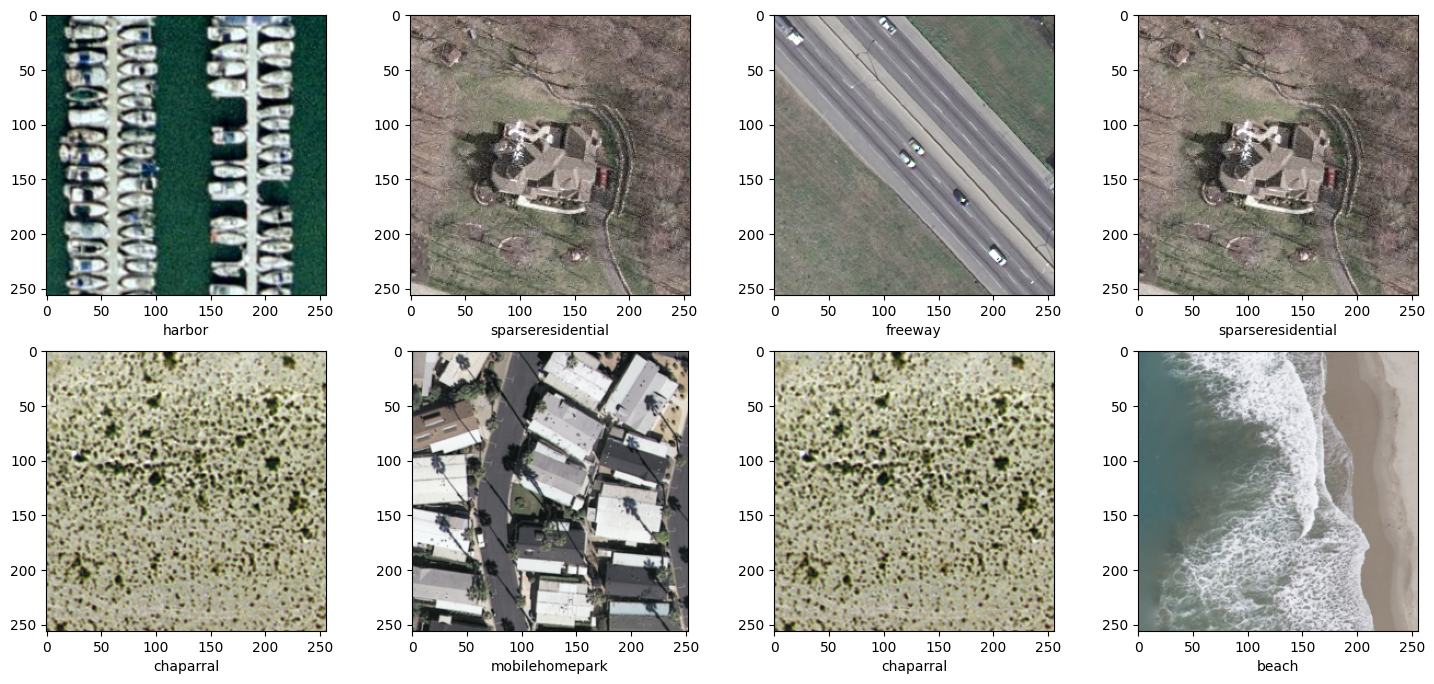

In [5]:
cat_idx=np.random.randint(0,21,8)
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
for i,cat in enumerate(cat_idx):
    image=plt.imread(directory+'/'+category_all[cat]+'/'+os.listdir(directory+'/'+category_all[cat])[0])
    axes[i//4,i%4].imshow(image)
    axes[i//4,i%4].set_xlabel(category_all[cat])
plt.show()

It seems a easy problem for human-beings, however algorithms only recognise numerical values,so Let dive into some numerical properties of those photos.Firstly, Lets look at the shape of the photos.

In [6]:
shape_dict={}
for i,cat in enumerate(category_all):
    for j in os.listdir(directory+'/'+cat+'/'):
        image=plt.imread(directory+'/'+cat+'/'+j)
        if image.shape not in shape_dict.keys():
            shape_dict[image.shape]=1
        else:
            shape_dict[image.shape]+=1
print(shape_dict)

{(256, 256, 3): 2056, (256, 253, 3): 6, (253, 256, 3): 3, (256, 255, 3): 4, (256, 247, 3): 1, (249, 256, 3): 2, (251, 256, 3): 5, (247, 256, 3): 1, (256, 254, 3): 3, (247, 247, 3): 9, (254, 256, 3): 2, (256, 242, 3): 1, (256, 250, 3): 2, (256, 249, 3): 1, (256, 252, 3): 2, (255, 256, 3): 1, (257, 257, 3): 1}


<b>we can see that majority of the photos have a shape of 256 X 256 X 3 ,However,there exists several photos with lower height or width.Let us locate their categories<b>

In [12]:
non_complete_photos=[]
for i,cat in enumerate(category_all):
    for j in os.listdir(directory+'/'+cat+'/'):
        image=plt.imread(directory+'/'+cat+'/'+j)
        if image.shape != (256,256,3):
            non_complete_photos.append(j)
print(non_complete_photos)

['airplane55.tif', 'airplane76.tif', 'airplane59.tif', 'tenniscourt36.tif', 'tenniscourt14.tif', 'river83.tif', 'river30.tif', 'parkinglot09.tif', 'parkinglot20.tif', 'storagetanks60.tif', 'storagetanks63.tif', 'storagetanks62.tif', 'overpass68.tif', 'overpass70.tif', 'overpass67.tif', 'overpass65.tif', 'overpass69.tif', 'overpass71.tif', 'overpass62.tif', 'overpass64.tif', 'overpass59.tif', 'overpass66.tif', 'sparseresidential22.tif', 'sparseresidential45.tif', 'sparseresidential46.tif', 'intersection99.tif', 'baseballdiamond35.tif', 'baseballdiamond45.tif', 'baseballdiamond93.tif', 'baseballdiamond15.tif', 'runway88.tif', 'runway61.tif', 'beach57.tif', 'buildings96.tif', 'harbor10.tif', 'harbor43.tif', 'mobilehomepark23.tif', 'mobilehomepark24.tif', 'mobilehomepark22.tif', 'mobilehomepark33.tif', 'golfcourse05.tif', 'golfcourse06.tif', 'golfcourse07.tif', 'golfcourse04.tif']


<b>How should we deal with those photos? There are several options,we can pad them to 256x256x3 or drop them during training,I choose to pad them to 256X256X3 since there are only 100 photos per category. Now let's load all the photos<b>

In [8]:
number_of_photos=100
number_of_cat=len(category_all)
patch_size=256
channels=3
def pad_image(image, target_size=(256, 256, 3)):
    pad_width = [(0, max(0, target_size[i] - image.shape[i])) for i in range(3)]
    padded_image = np.pad(image, pad_width, mode='constant')
    return padded_image

In [9]:
images_orig=[]
labels_num=[]
for i,cat in enumerate(category_all):
    for j in range(100):
        name=str(j) if j >=10 else ('0'+str(j))
        image=plt.imread(directory+'/'+cat+'/'+cat+name+'.tif')
        image=pad_image(image)#pad all image to 256*256*3
        resized_image=resize(image,(patch_size//4,patch_size//4,channels))#-->64*64*3
        arr=np.asarray(resized_image)
        images_orig.append(arr)
        labels_num.append(i)
images_orig=np.asarray(images_orig)
labels_num=np.asarray(labels_num)
# np.save(directory+'all_images.npy',images_orig)
# np.save(directory+'labels_num.npy',labels_num)

In [10]:
images_orig=np.load(directory+'all_images.npy')
labels_num=np.load(directory+'labels_num.npy')

In [12]:
labels=to_categorical(labels_num,21)

In [13]:
print(images_orig.shape)#total number of photos as shown before :2100 and all in one shape: 64*64*3
print(labels.shape)

(2100, 64, 64, 3)
(2100, 21)


In [14]:
images_orig.min(),images_orig.max()#we have standazise all the photos

(0.0, 1.0)

In [15]:
X_train,X_test,y_train,y_test=train_test_split(images_orig,labels,test_size=0.2)

In [16]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.2)

In [17]:
len(X_val)#0.8*0.2*2100=336 val photos

336

<font size=6><b>
Model Building and Analysis:
</b></font>

In [18]:
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Input,Dense,Conv2D,GlobalAveragePooling2D,AveragePooling2D,MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D,Dropout,Flatten,add,Reshape,Activation,BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [45]:
input_size=(64,64,3)
pool_size = (2, 2)
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',input_shape=input_size))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Flatten())#tranform to 1d vector
model.add(Dense(128,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(21,activation='softmax'))

In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 21)             │         1,365 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,151,573 (4.39 MB)

 Trainable params: 1,151,573 (4.39 MB)

 Non-trainable params: 0 (0.00 B)

<b>Now let us train our first model<b>

In [36]:
opt=Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
history=model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=50,verbose=2)

Epoch 1/50
42/42 - 6s - 150ms/step - accuracy: 0.0446 - loss: 3.0517 - val_accuracy: 0.0506 - val_loss: 3.0266
Epoch 2/50
42/42 - 0s - 6ms/step - accuracy: 0.0774 - loss: 3.0175 - val_accuracy: 0.0952 - val_loss: 2.9992
Epoch 3/50
42/42 - 0s - 6ms/step - accuracy: 0.0975 - loss: 2.9758 - val_accuracy: 0.1190 - val_loss: 2.9284
Epoch 4/50
42/42 - 0s - 6ms/step - accuracy: 0.1153 - loss: 2.9081 - val_accuracy: 0.1250 - val_loss: 2.8326
Epoch 5/50
42/42 - 0s - 6ms/step - accuracy: 0.1548 - loss: 2.7877 - val_accuracy: 0.1339 - val_loss: 2.7085
Epoch 6/50
42/42 - 0s - 6ms/step - accuracy: 0.1696 - loss: 2.7283 - val_accuracy: 0.1369 - val_loss: 2.6522
Epoch 7/50
42/42 - 0s - 6ms/step - accuracy: 0.1823 - loss: 2.6476 - val_accuracy: 0.1815 - val_loss: 2.5846
Epoch 8/50
42/42 - 0s - 6ms/step - accuracy: 0.1726 - loss: 2.6257 - val_accuracy: 0.1875 - val_loss: 2.5014
Epoch 9/50
42/42 - 0s - 6ms/step - accuracy: 0.1905 - loss: 2.5641 - val_accuracy: 0.2054 - val_loss: 2.4532
Epoch 10/50
42/42

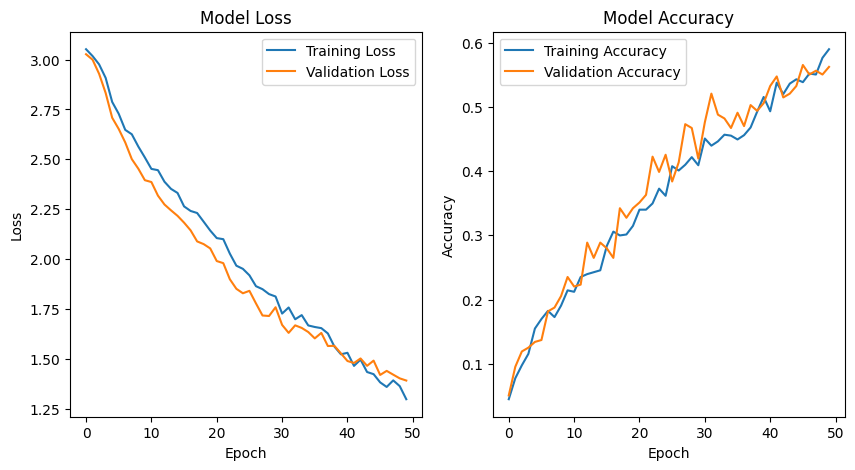

In [38]:
def result(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
result(history)

<b>As we notice above,the train and validation loss keeps dropping sharply during all the epoches ,which may indicate that our model underfit,so let us try a higher learning rate<b>

In [40]:
opt=Adam(learning_rate=0.0002)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
history=model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=50,verbose=2)

Epoch 1/50
42/42 - 6s - 150ms/step - accuracy: 0.0655 - loss: 3.0260 - val_accuracy: 0.0923 - val_loss: 2.9903
Epoch 2/50
42/42 - 0s - 6ms/step - accuracy: 0.1071 - loss: 2.9232 - val_accuracy: 0.1607 - val_loss: 2.8340
Epoch 3/50
42/42 - 0s - 6ms/step - accuracy: 0.1295 - loss: 2.7731 - val_accuracy: 0.1518 - val_loss: 2.6473
Epoch 4/50
42/42 - 0s - 5ms/step - accuracy: 0.1674 - loss: 2.6101 - val_accuracy: 0.1845 - val_loss: 2.4642
Epoch 5/50
42/42 - 0s - 6ms/step - accuracy: 0.2091 - loss: 2.5047 - val_accuracy: 0.2440 - val_loss: 2.3306
Epoch 6/50
42/42 - 0s - 6ms/step - accuracy: 0.2329 - loss: 2.4142 - val_accuracy: 0.2738 - val_loss: 2.2261
Epoch 7/50
42/42 - 0s - 6ms/step - accuracy: 0.2500 - loss: 2.3255 - val_accuracy: 0.3571 - val_loss: 2.1436
Epoch 8/50
42/42 - 0s - 6ms/step - accuracy: 0.3006 - loss: 2.2361 - val_accuracy: 0.3244 - val_loss: 2.0399
Epoch 9/50
42/42 - 0s - 6ms/step - accuracy: 0.3192 - loss: 2.1390 - val_accuracy: 0.3274 - val_loss: 2.0135
Epoch 10/50
42/42

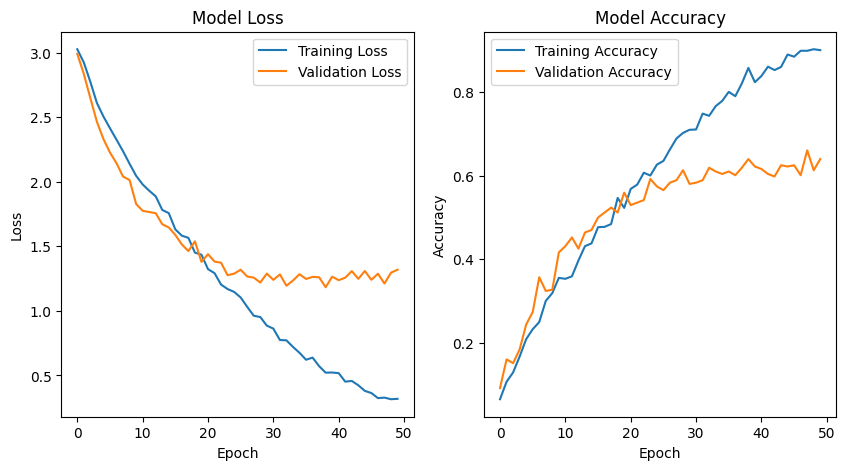

In [41]:
result(history)

<b>We can see here,with a higher learning rate,the model converges faster and thanks to drop out layer we implement,the model doesn't overfit.So let's try finetune other hyperparameters and the model to get a better accuracy. <b>

<b>First,let us try a different batch_size<b>

In [46]:
opt=Adam(learning_rate=0.0002)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
history=model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=50,verbose=2,batch_size=10)

Epoch 1/50


2024-04-20 11:19:04.886072: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8192: 3.03962, expected 2.52262
2024-04-20 11:19:04.886138: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8193: 4.06255, expected 3.54556
2024-04-20 11:19:04.886148: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8195: 3.18037, expected 2.66337
2024-04-20 11:19:04.886156: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8201: 4.08823, expected 3.57124
2024-04-20 11:19:04.886164: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8202: 4.06331, expected 3.54632
2024-04-20 11:19:04.886172: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8205: 4.07024, expected 3.55324
2024-04-20 11:19:04.886180: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8212: 3.88219, expected 3.3652
2024-04-20 11:19:04.886189: E exter

135/135 - 14s - 105ms/step - accuracy: 0.0521 - loss: 3.0354 - val_accuracy: 0.0952 - val_loss: 2.9438
Epoch 2/50
135/135 - 1s - 4ms/step - accuracy: 0.1064 - loss: 2.8814 - val_accuracy: 0.1667 - val_loss: 2.6943
Epoch 3/50
135/135 - 1s - 4ms/step - accuracy: 0.1749 - loss: 2.6301 - val_accuracy: 0.2530 - val_loss: 2.3162
Epoch 4/50
135/135 - 1s - 4ms/step - accuracy: 0.2321 - loss: 2.3893 - val_accuracy: 0.3482 - val_loss: 2.1034
Epoch 5/50
135/135 - 1s - 4ms/step - accuracy: 0.3118 - loss: 2.1559 - val_accuracy: 0.3810 - val_loss: 1.9439
Epoch 6/50
135/135 - 1s - 4ms/step - accuracy: 0.3296 - loss: 2.1040 - val_accuracy: 0.4405 - val_loss: 1.8633
Epoch 7/50
135/135 - 1s - 4ms/step - accuracy: 0.3616 - loss: 1.9115 - val_accuracy: 0.4643 - val_loss: 1.7247
Epoch 8/50
135/135 - 1s - 4ms/step - accuracy: 0.3996 - loss: 1.7879 - val_accuracy: 0.4821 - val_loss: 1.6288
Epoch 9/50
135/135 - 1s - 4ms/step - accuracy: 0.4754 - loss: 1.6157 - val_accuracy: 0.5238 - val_loss: 1.5241
Epoch 10/

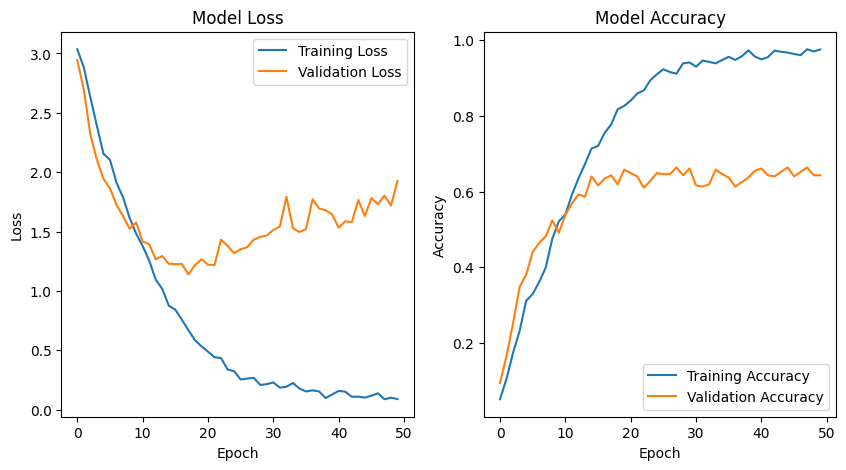

In [47]:
result(history)

<b>With a low batch_size,the model converges ultra fast.Compared to the last try,the model reach a 90%train accuracy at epoch-25 which is 25-epoches faster,However,we can see fro mthe validation loss,the model turns to be overfitting a little bit,Now let us try a different model structure by adding another layer of convolution<b>

In [48]:
input_size=(64,64,3)
pool_size = (2, 2)
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',input_shape=input_size))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Flatten())#tranform to 1d vector
model.add(Dense(256,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(21,activation='softmax'))

In [49]:
opt=Adam(learning_rate=0.0002)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
history=model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=50,verbose=2,batch_size=10)

Epoch 1/50


W0000 00:00:1713614218.549900      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713614226.123487      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/135 - 17s - 124ms/step - accuracy: 0.0499 - loss: 3.0458 - val_accuracy: 0.0982 - val_loss: 3.0292
Epoch 2/50
135/135 - 1s - 4ms/step - accuracy: 0.0744 - loss: 2.9620 - val_accuracy: 0.1339 - val_loss: 2.7452
Epoch 3/50
135/135 - 1s - 4ms/step - accuracy: 0.1124 - loss: 2.7646 - val_accuracy: 0.1310 - val_loss: 2.7035
Epoch 4/50
135/135 - 1s - 4ms/step - accuracy: 0.1436 - loss: 2.6561 - val_accuracy: 0.1905 - val_loss: 2.5580
Epoch 5/50
135/135 - 1s - 4ms/step - accuracy: 0.1793 - loss: 2.5592 - val_accuracy: 0.2411 - val_loss: 2.3297
Epoch 6/50
135/135 - 1s - 4ms/step - accuracy: 0.2299 - loss: 2.3825 - val_accuracy: 0.2619 - val_loss: 2.1388
Epoch 7/50
135/135 - 1s - 4ms/step - accuracy: 0.2708 - loss: 2.2710 - val_accuracy: 0.3512 - val_loss: 1.9938
Epoch 8/50
135/135 - 1s - 4ms/step - accuracy: 0.3251 - loss: 2.1140 - val_accuracy: 0.4345 - val_loss: 1.8314
Epoch 9/50
135/135 - 1s - 5ms/step - accuracy: 0.3504 - loss: 1.9705 - val_accuracy: 0.4762 - val_loss: 1.6742
Epoch 10/

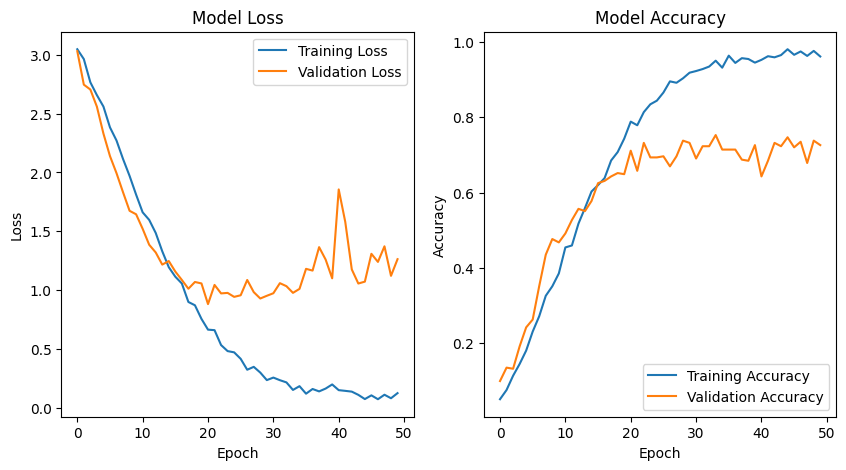

In [50]:
result(history)

With another layer of convolution,Maxpooling and MLP,we reach a higher accuracy.How about one more layers?

In [51]:
input_size=(64,64,3)
pool_size = (2, 2)
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',input_shape=input_size))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Flatten())#tranform to 1d vector
model.add(Dense(512,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(256,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(21,activation='softmax'))

In [52]:
opt=Adam(learning_rate=0.0002)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
history=model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=50,verbose=2,batch_size=10)

Epoch 1/50
135/135 - 20s - 152ms/step - accuracy: 0.0484 - loss: 3.0449 - val_accuracy: 0.0863 - val_loss: 3.0109
Epoch 2/50
135/135 - 1s - 5ms/step - accuracy: 0.0677 - loss: 2.9825 - val_accuracy: 0.0863 - val_loss: 2.9081
Epoch 3/50
135/135 - 1s - 5ms/step - accuracy: 0.0930 - loss: 2.8677 - val_accuracy: 0.0804 - val_loss: 2.7457
Epoch 4/50
135/135 - 1s - 5ms/step - accuracy: 0.1049 - loss: 2.7807 - val_accuracy: 0.1280 - val_loss: 2.6762
Epoch 5/50
135/135 - 1s - 5ms/step - accuracy: 0.1451 - loss: 2.6646 - val_accuracy: 0.1845 - val_loss: 2.4273
Epoch 6/50
135/135 - 1s - 5ms/step - accuracy: 0.1823 - loss: 2.5492 - val_accuracy: 0.2470 - val_loss: 2.3367
Epoch 7/50
135/135 - 1s - 5ms/step - accuracy: 0.2307 - loss: 2.3544 - val_accuracy: 0.3244 - val_loss: 2.1074
Epoch 8/50
135/135 - 1s - 5ms/step - accuracy: 0.2634 - loss: 2.2362 - val_accuracy: 0.3423 - val_loss: 1.9825
Epoch 9/50
135/135 - 1s - 5ms/step - accuracy: 0.3274 - loss: 2.0839 - val_accuracy: 0.3363 - val_loss: 1.925

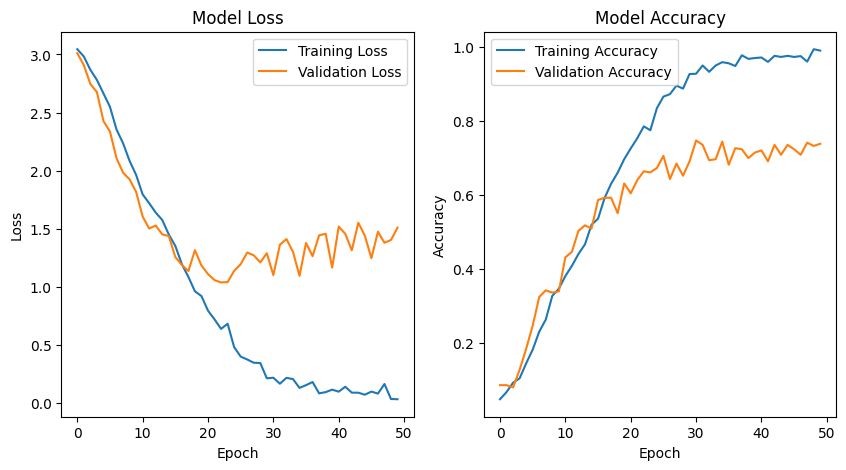

In [53]:
result(history)

<b>We have a even better score.So, the more layers,the better?Let us add more layers<b>

In [62]:
input_size=(64,64,3)
pool_size = (2, 2)
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',input_shape=input_size))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=1024,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Flatten())#tranform to 1d vector
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(256,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(21,activation='softmax'))

In [58]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 2, 2, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 21)             │         1,365 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,036,437 (30.66 MB)

 Trainable params: 8,036,437 (30.66 MB)

 Non-trainable params: 0 (0.00 B)

Compared to our first model,this model have 7 times more parameters( 8,036,437  vs 1,151,573)!which means a huge computional complexity increase.Let us see how this model performs

In [63]:
opt=Adam(learning_rate=0.0002)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
history=model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=50,verbose=2,batch_size=10)

Epoch 1/50
135/135 - 26s - 196ms/step - accuracy: 0.0558 - loss: 3.0451 - val_accuracy: 0.0446 - val_loss: 3.0391
Epoch 2/50
135/135 - 1s - 8ms/step - accuracy: 0.0528 - loss: 3.0404 - val_accuracy: 0.0804 - val_loss: 2.9885
Epoch 3/50
135/135 - 1s - 8ms/step - accuracy: 0.0818 - loss: 2.9218 - val_accuracy: 0.0774 - val_loss: 2.7884
Epoch 4/50
135/135 - 1s - 8ms/step - accuracy: 0.0990 - loss: 2.7953 - val_accuracy: 0.1071 - val_loss: 2.6557
Epoch 5/50
135/135 - 1s - 8ms/step - accuracy: 0.0990 - loss: 2.7222 - val_accuracy: 0.1012 - val_loss: 2.6207
Epoch 6/50
135/135 - 1s - 8ms/step - accuracy: 0.1004 - loss: 2.7044 - val_accuracy: 0.0952 - val_loss: 2.5846
Epoch 7/50
135/135 - 1s - 8ms/step - accuracy: 0.1384 - loss: 2.5938 - val_accuracy: 0.1190 - val_loss: 2.4118
Epoch 8/50
135/135 - 1s - 8ms/step - accuracy: 0.1295 - loss: 2.5237 - val_accuracy: 0.1190 - val_loss: 2.4667
Epoch 9/50
135/135 - 1s - 8ms/step - accuracy: 0.1496 - loss: 2.4528 - val_accuracy: 0.1220 - val_loss: 2.307

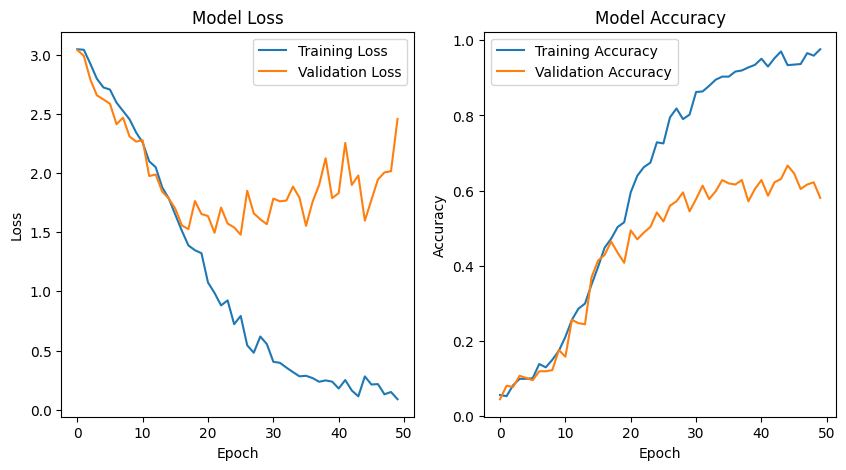

In [64]:
result(history)

<b>whoops,looks like we get a worse result compared to last model.Why? The more convolution layers we have,the more 'abstract' the information the mlp have to deal with.As the input passes through successive convolutional layers, the network learns to detect more complex and abstract patterns. Early layers in the network typically capture low-level features such as edges, textures, and simple shapes. These low-level features are then combined and transformed by subsequent layers to represent higher-level concepts or objects present in the input data.
By stacking multiple convolutional layers, the network can learn hierarchical representations of features, with each layer building upon the representations learned by the previous layers. This allows CNNs to effectively capture intricate patterns and structures in the input data, leading to superior performance in tasks like image classification, object detection, and segmentation.Let us roll back to the old model<b>

In [69]:
input_size=(64,64,3)
pool_size = (2, 2)
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',input_shape=input_size))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Flatten())#tranform to 1d vector
model.add(Dense(512,activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(256,activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(21,activation='softmax'))

Let us try finetune another hyparameter,the drop-out rate

In [70]:
opt=Adam(learning_rate=0.0002)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
history=model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=50,verbose=2,batch_size=10)

Epoch 1/50
135/135 - 20s - 150ms/step - accuracy: 0.0551 - loss: 3.0502 - val_accuracy: 0.0149 - val_loss: 3.0469
Epoch 2/50
135/135 - 1s - 5ms/step - accuracy: 0.0528 - loss: 3.0442 - val_accuracy: 0.0565 - val_loss: 3.0460
Epoch 3/50
135/135 - 1s - 5ms/step - accuracy: 0.0528 - loss: 3.0461 - val_accuracy: 0.0357 - val_loss: 3.0445
Epoch 4/50
135/135 - 1s - 5ms/step - accuracy: 0.0506 - loss: 3.0443 - val_accuracy: 0.0357 - val_loss: 3.0446
Epoch 5/50
135/135 - 1s - 5ms/step - accuracy: 0.0387 - loss: 3.0421 - val_accuracy: 0.0357 - val_loss: 3.0413
Epoch 6/50
135/135 - 1s - 5ms/step - accuracy: 0.0513 - loss: 3.0407 - val_accuracy: 0.0565 - val_loss: 3.0395
Epoch 7/50
135/135 - 1s - 5ms/step - accuracy: 0.0551 - loss: 3.0346 - val_accuracy: 0.0268 - val_loss: 3.0451
Epoch 8/50
135/135 - 1s - 9ms/step - accuracy: 0.0670 - loss: 3.0348 - val_accuracy: 0.0536 - val_loss: 2.9972
Epoch 9/50
135/135 - 1s - 5ms/step - accuracy: 0.0737 - loss: 2.9934 - val_accuracy: 0.0565 - val_loss: 2.920

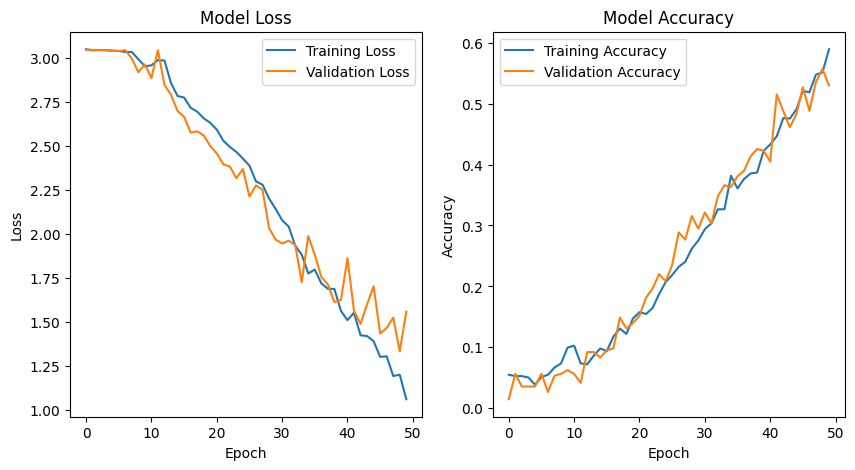

In [71]:
result(history)

We can see here that with a high drop rate,the model converges way slower,Also the accuracy is lower,while dropout is intended to improve generalization by preventing overfitting, setting the dropout rate too high can lead to decreased training accuracy. This is because dropout randomly deactivates neurons during training, which can hinder the model's ability to learn from the data effectively.What is more? Setting the dropout rate too high can  potentially make the model more sensitive to variations in the input data or noise.

<b>So finally,we got our final model<b>

In [78]:
input_size=(64,64,3)
pool_size = (2, 2)
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',input_shape=input_size))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=pool_size,strides=(2,2)))
model.add(Flatten())#tranform to 1d vector
model.add(Dense(512,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(256,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(21,activation='softmax'))

In [79]:
opt=Adam(learning_rate=0.0002)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
history=model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=50,verbose=2,batch_size=10)

Epoch 1/50
135/135 - 19s - 142ms/step - accuracy: 0.0513 - loss: 3.0346 - val_accuracy: 0.0833 - val_loss: 3.0100
Epoch 2/50
135/135 - 1s - 5ms/step - accuracy: 0.0833 - loss: 2.8997 - val_accuracy: 0.1161 - val_loss: 2.7663
Epoch 3/50
135/135 - 1s - 5ms/step - accuracy: 0.0863 - loss: 2.7917 - val_accuracy: 0.1339 - val_loss: 2.6397
Epoch 4/50
135/135 - 1s - 5ms/step - accuracy: 0.1124 - loss: 2.7017 - val_accuracy: 0.1518 - val_loss: 2.5120
Epoch 5/50
135/135 - 1s - 5ms/step - accuracy: 0.1711 - loss: 2.5739 - val_accuracy: 0.2173 - val_loss: 2.3487
Epoch 6/50
135/135 - 1s - 5ms/step - accuracy: 0.1786 - loss: 2.4561 - val_accuracy: 0.2232 - val_loss: 2.2587
Epoch 7/50
135/135 - 1s - 5ms/step - accuracy: 0.2336 - loss: 2.2689 - val_accuracy: 0.3214 - val_loss: 2.0038
Epoch 8/50
135/135 - 1s - 5ms/step - accuracy: 0.2879 - loss: 2.0846 - val_accuracy: 0.3393 - val_loss: 1.9201
Epoch 9/50
135/135 - 1s - 5ms/step - accuracy: 0.3192 - loss: 2.0010 - val_accuracy: 0.4167 - val_loss: 1.712

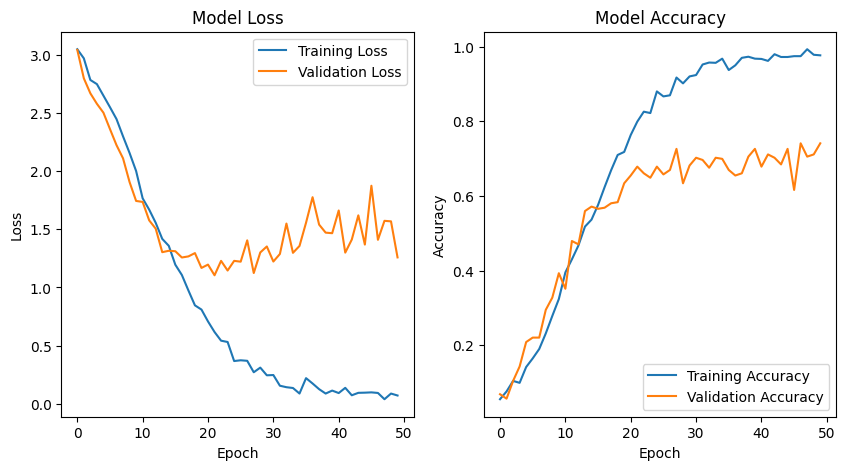

In [74]:
result(history)

<font size=6><b>
Result and Conclusions:
</b></font>

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        16
           1       0.95      0.73      0.83        26
           2       0.80      1.00      0.89        12
           3       0.94      0.85      0.89        20
           4       0.40      0.25      0.31        16
           5       1.00      0.89      0.94        19
           6       0.52      0.63      0.57        19
           7       0.89      0.89      0.89        19
           8       0.48      0.68      0.57        19
           9       0.63      0.77      0.69        22
          10       0.94      0.94      0.94        17
          11       1.00      0.52      0.68        25
          12       0.48      0.50      0.49        24
          13       0.77      0.94      0.85        18
          14       0.65      0.62      0.63        21
          15       1.00      0.83      0.91        12
          16      

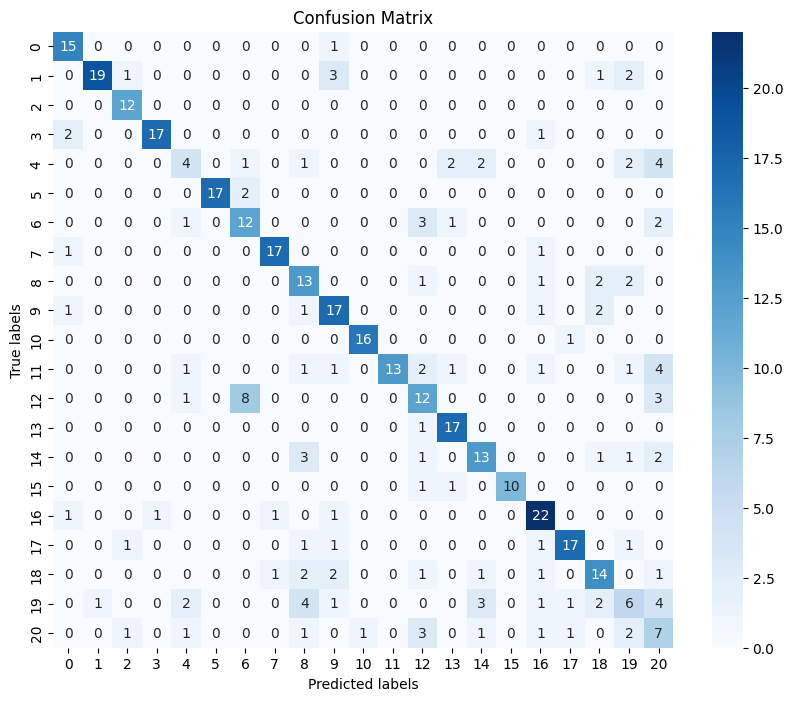

In [82]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_val_labels = np.argmax(y_test, axis=1)
print("Classification Report:")
print(classification_report(y_val_labels, y_pred_labels))
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_val_labels, y_pred_labels), annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(21), yticklabels=range(21))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

<b>From the confusion matrix, we can see that there is still serious mislabel problem for category-6(overpass) and category-20(tenniscourt) Which is pretty reasonable because tenniscourt are not so different compared to other categories ,like buildings , A better model still need to be built to address that problem<b>

  <b>As for future works,Since I only have limited time for this project, I didn't go through a lot of combination of hyperparameters.So in the future I may conduct more extensive hyperparameter tuning using advanced optimization techniques like Bayesian optimization.What is more, I can experiment with more sophisticated model architectures, including state-of-the-art deep learning architectures (EfficientNet).And, incorporate advanced regularization techniques such as mixup, label smoothing, or self-supervised learning.<b>